In [2]:
!apt-get install swig -y
!pip install Cython numpy
!pip install distributed
!pip install auto-sklearn==0.12.3
!pip install pydataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,054 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpackin

     |████████████████████████████████| 15.9 MB 123 kB/s 
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939430 sha256=ac582678646856e8a07858d3e0467ab107e2015fd74fad83aff0000c2aa0b15f
  Stored in directory: /root/.cache/pip/wheels/32/26/30/d71562a19eed948eaada9a61b4d722fa358657a3bfb5d151e2
Successfully built pydataset


In [1]:
import sklearn
print(sklearn.__version__)

0.24.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls 'drive/My Drive/Project/faceRecog/facenet_code_fix'

arial.ttf  facenet0618.ipynb  facenet.ipynb
data	   facenet0817.ipynb  finetune.ipynb


**Define function-helpers for data preprocessing**

In [4]:
import os 
import glob 

from PIL import Image, ImageDraw


# 폴더의 이미지들을 받아와 배열의 형태로 받아오는 함수
def get_files(path='./', ext=('.png', '.jpeg', '.jpg')):
    """ Get all image files """
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files

# 경로의 이미지를 rgb로 바꾸고, 저장하기
def to_rgb_and_save(path):
    """ Some of the images may have RGBA mode """
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
            img.save(p)

**Define image path**



In [5]:
#ABS_PATH = '/content/drive/My Drive/Colab Notebooks/facenet/facenet_code_fix'
ABS_PATH = 'drive/My Drive/Project/faceRecog/facenet_code_fix'
DATA_PATH = os.path.join(ABS_PATH, 'data')

# 바로 cropped 된 데이터 폴더의 경로를 ALIGNED_ 에 저장한다.
ALIGNED_TRAIN_DIR = os.path.join(DATA_PATH, 'train_images_cropped')
ALIGNED_TEST_DIR = os.path.join(DATA_PATH, 'test_images_cropped')


**Preparing data**

In [6]:
from collections import Counter 

# trainF, testF에 cropped 된 것을 넣어준다.
trainF, testF = get_files(ALIGNED_TRAIN_DIR), get_files(ALIGNED_TEST_DIR)

# prepare info for printing
# ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR 를 받아서 폴더 내부의 데이터 개수를 체크.
trainC, testC = Counter(map(os.path.dirname, trainF)), Counter(map(os.path.dirname, testF))
train_total, train_text  = sum(trainC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in trainC.items()])
test_total, test_text  = sum(testC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in testC.items()])

print(f'Train files\n\tpath: {ALIGNED_TRAIN_DIR}\n\ttotal number: {train_total}\n{train_text}')
print(f'Train files\n\tpath: {ALIGNED_TEST_DIR}\n\ttotal number: {test_total}\n{test_text}')

Train files
	path: drive/My Drive/Project/faceRecog/facenet_code_fix/data/train_images_cropped
	total number: 16
	- iu - 2
	- jaeyoung - 2
	- june - 2
	- key - 2
	- minho - 2
	- myungho - 2
	- onew - 2
	- taemin - 2
Train files
	path: drive/My Drive/Project/faceRecog/facenet_code_fix/data/test_images_cropped
	total number: 8
	- iu - 1
	- jaeyoung - 1
	- june - 1
	- key - 1
	- minho - 1
	- myungho - 1
	- onew - 1
	- taemin - 1


In [7]:
# 이미지를 RGB의 형태로 바꿔야 한다.
to_rgb_and_save(trainF), to_rgb_and_save(testF)

(None, None)

**Image plotter fuctions**

In [8]:
from math import ceil 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline 

from matplotlib.patches import Ellipse

# 폴더 속의 이미지를 plot하는 함수들 : imshow(), plot_gallery(), plot()
# ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR, augmentation한 데이터를 plot할 때 이용
# augmentation data의 경우는 getEmbeds()를 통해 plot.
def imshow(img, ax, title):  
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"), 
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none", 
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None): 
    if figsize is None: 
        figsize = (18, ncols) if ncols < 10 else (18, 20)  
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid): 
        if i == len(images): break 
        imshow(images[i], ax, titles[i] if titles is not None else '')

    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)): 
    if paths is not None and len(paths): 
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        if axtitle: 
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images): 
        if isinstance(images, list): 
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        # Rescale
        if images[0].max() > 1: 
            images /= 255. 

        if not isinstance(images, np.ndarray): 
            if images.size(1) == 3 or 1: 
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)

    else: 
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

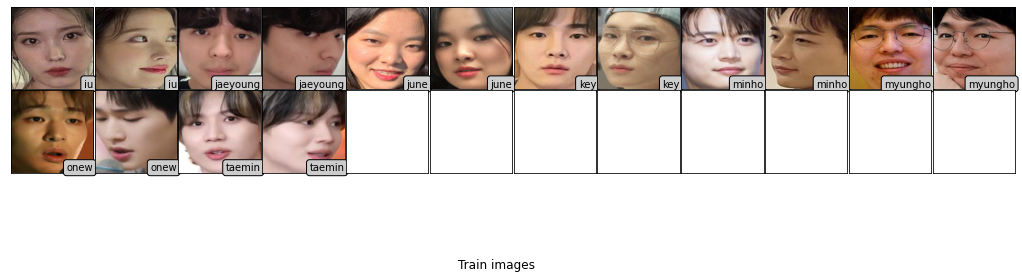

In [9]:
plot(paths=trainF, title='Train images')

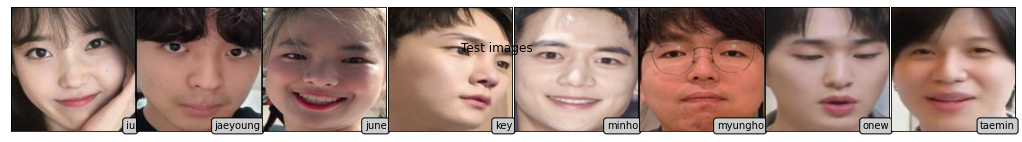

In [10]:
plot(paths=testF, title='Test images')

**Install facenet_pytorch with MTCNN detection and pretrained vggface-2 InceptionResnetV1**

In [11]:
!pip install facenet-pytorch 

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization

     |████████████████████████████████| 1.9 MB 5.5 MB/s 


**Function for cropping and saving images based on MTCNN detector**

In [12]:
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


**Install albumentations for augmentations**

In [13]:
# augmentation

!pip install albumentations

import albumentations as A

     |████████████████████████████████| 631 kB 5.4 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=ef6783a330ac9a8f367e934f7d7766d9b6f18dad17a5085dcd43e396605eb895
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


**Transformer for data**

In [14]:
from facenet_pytorch import fixed_image_standardization

# 이미지를 transform 할 때의 기준(템플릿).
# numpy float 형, 텐서의 형태로, 이미지 정규화하기
standard_transform = transforms.Compose([
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])

# 그리고 augmentation를 위한 그 템플릿(mask)
aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
], p=1)

# 위에서 정의한 standard_transform과 aug_mask를 train과 test data에 적용하도록 한다.
# aug는 train만, standard_transform은 train과 test 둘 모두에 적용한다.
# 아래의 ImageFolder에서 data에 대해 적용한다.
transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                                 standard_transform
    ]),
    'test': standard_transform
}

**DataLoader for train/test**

In [15]:
from torch.utils.data import SubsetRandomSampler

# augmentation을 적용하고, 데이터를 정규화.
# dataloader로 pytorch에서 사용할 수 있도록 올리기.


b = 32

# train image에 standard_transform만 적용해 trainD 에 넣음.
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)
# Augmented train images. transform을 적용해 trainD_agu에 넣음.
trainD_aug = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
# Train DataLoader
trainL = DataLoader(trainD, batch_size=b, num_workers=2)
trainL_aug = DataLoader(trainD_aug, batch_size=b, num_workers=2)

# test images 
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
# Test DataLoader
testL = DataLoader(testD, batch_size=b, num_workers=2)

# Convert encoded labels to named claasses
# IDX_TO_CLASS : 사람 이름(index) 배열
IDX_TO_CLASS = np.array(list(trainD.class_to_idx.keys()))
CLASS_TO_IDX = dict(trainD.class_to_idx.items())


**Prepare model**

In [16]:
#finetune version은 아래의 블록
from facenet_pytorch import InceptionResnetV1

model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

**Function for embedding extraction**

In [17]:
# augmentation한 data와 원본 data를 embedding하여, '.npz'의 형태로 출력


def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

def getEmbeds(model, n, loader, imshow=False, n_img=5):
    model.eval()
    # image들 저장
    images = []

    embeds, labels = [], []
    # tqdm : 진행바
    for n_i in tqdm.trange(n): 
        for i, (x, y) in enumerate(loader, 1): 
            if imshow and i == 1: 
                inds = np.random.choice(x.size(0), min(x.size(0), n_img))
                images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

            embed = model(x.to(device))
            embed = embed.data.cpu().numpy()
            embeds.append(embed), labels.extend(y.data.cpu().numpy())

    if imshow: 
        # augmentation한 이미지가 담긴 images를 plot.
        plot(images=np.concatenate(images))

    return np.concatenate(embeds), np.array(labels)

**Extract embeddings**

In [18]:
# Train data embedding
trainEmbeds, trainLabels = getEmbeds(model, 1, trainL, False)
trainEmbeds_aug, trainLabels_aug = getEmbeds(model, 50, trainL_aug, imshow=True, n_img=3)

trainEmbeds = np.concatenate([trainEmbeds, trainEmbeds_aug])
trainLabels = np.concatenate([trainLabels, trainLabels_aug])

# Test embeddings 
testEmbeds, testLabels = getEmbeds(model, 1, testL, False)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# embedding 한 것들을 '.npz'의 형태로 저장
# 이때, path는 TRAIN_EMBEDS와 TEST_EMBEDS.
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')

np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

# 저장한 embedding load
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

# 이름 label
trainLabels, testLabels = IDX_TO_CLASS[trainLabels], IDX_TO_CLASS[testLabels]

**Find optimal parameters for SVC classifier and train**

In [20]:
# data
# X : 얼굴 사진 data embedding
# y : taget, 이름 label
X = np.copy(trainEmbeds)
y = np.array([CLASS_TO_IDX[label] for label in trainLabels])

print(f'X train embeds size: {X.shape}')
print(f'Tagret train size: {y.shape}')

X train embeds size: (816, 512)
Tagret train size: (816,)


In [21]:
# model 저장
import joblib

**As we see, in order to find optimal parameters among ```'param_grid'``` the whole search process took ~ 1.5 hours**

In [22]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')

# 최적의 parameter 찾기 위한 param_grid
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 10, 'probability': True, 'random_state': 3}
model = SVC(**model_params)
clf = GridSearchCV(model, param_grid)
clf.fit(X, y)

print('Best estimator: ', clf.best_estimator_)
print('Best params: ', clf.best_params_)


SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
joblib.dump(clf, SVM_PATH)
clf = joblib.load(SVM_PATH)

Best estimator:  SVC(C=5000.0, class_weight='balanced', gamma=0.1, kernel='poly', max_iter=10,
    probability=True, random_state=3)
Best params:  {'C': 5000.0, 'gamma': 0.1, 'kernel': 'poly'}
CPU times: user 1min 43s, sys: 155 ms, total: 1min 44s
Wall time: 1min 43s


**Load & save SVC model, basically weights**